# Comparing a Deep Learning and a Non-deep Learning Algorithm on Semantic Contextual Similarity

## What is Semantic Contextual Similarity (STS)
Semantic Textual Similarity (STS) is the task of evaluating how similar two texts are in terms of meaning. It does so by assigning a score on similarity of the two texts. The higher the score is, the more similar the two texts are. 0 score means the two are not similar at all, and 5 means the two mean the same thing. For example, 'You got it right.' and 'You've got it right.' mean the same thing, so we give a score of 5 for this text pair, though they are phrased slightly differently, and 'Yes, there is a chemical difference.' and 'Yes, there is a reason for it.' have many matching words, we give this pair a score of 0 because they mean completely different things. So STS is a regression problem, and the input is a pair of texts in a certain language, and the output is a real number between 0 and 5.


## The Goal
In this article I compare two algorithms, one of deep learning method, the other non-deep learning, from performance and cost aspect to demonstrate the pros and cons of deep learning algorithm on one of the NLP applications, semantic contextual similarity.  In this project, TF-IDF from sklearn is used as the non-deep-learning method and Sentence Transformer is used as the deep learning one.  By learning the pros and cons of these very different STS algorithms you can choose the proper approach to solve the problem effectively.


## Why Choose STS?

STS is one of the most important NLP tasks that has application in neural machine translation (NMT), summarization, question answering (QA), NLI, information retrieval, and semantic search.  
Accurately modeling the semantic similarity of sentences is a foundational language understanding problem relevant to the above mentioned applications.  These applications widely appear in large scale search engines, recommender systems, automated answering systems, digital phone call, predictive text, data and text analysis, just to name a few.

## What Models are used for Comparison
Non-deep learning methods such as TF-IDF have been around for a while to solve STS problems but in recent years deep learning method such as transformer has achieved far better result in terms of performance in STS, and in this project The models chosen for this project are TfidfVectorizer from sklearn, which is TF-IDF based unsupervised learning algorithm, and Sentence Transformer from sbert.net, a transformer based pre-trained model.

## How are Models/Algorithms Evaluated?
For performance/quality evaluation, I use a dataset from the STS benchmark.  It consists of examples of English text pairs and a score measuring the semantic similarity of the pair. The scores are annotated by human specialists. With other datasets from STS benchmark, the dataset has been used by researchers on study of text similarity and semantic representations.  STS benchmark is a publicly available dataset that is commonly used for evaluation/assessment of new models/algorithms.  The benchmark dataset is used to measure the performance of each model by the Pearson and Spearman correlation of predicted similarity score and that of label (Human judged) from the benchmark. Details on how evaluation is performed and the metrics and methods used is in the Analysis section.


In [ ]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import stopwords
import numpy as np
import csv
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## What is the Dataset and Where does it Come from

To support research study on STS and related problems, STS shared tasks established a venue for standardized evaluation of state-of-the-art algorithms and models.  This way when a new model comes out and we will have a benchmark to assess its performance in a standardized way.  STS benchmark was a result of that and the STS English dataset from the STS benchmark is used in this project to compare the performance of the two models.

This is the link to STS benchmark:
https://ixa2.si.ehu.eus/stswiki/index.php/STSbenchmark

Data in the dataset come from image captions, news headlines and user forums from years 2012 to 2017.  Score annotation is crowdsourced from Amazon
Mechanical Turk.  For details please refer http://www.aclweb.org/anthology/S/S17/S17-2001.pdf.
In this project I am evaluating models on general purpose STS tasks, therefore I ignore columns such as genre and years and only use scores, sentence1, sentence 2, which are listed as column 4, 5 and 6 respectively.
This dataset consists of three parts, training, dev, and test.
               train  dev test total
       -----------------------------
       news     3299  500  500  4299
       caption  2000  625  625  3250
       forum     450  375  254  1079
       -----------------------------
       total    5749 1500 1379  8628

In [ ]:
!mkdir data
!wget http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz -P data
!tar -xvf data/Stsbenchmark.tar.gz -C data
#!pip install --upgrade gensim

In [ ]:
#!rm -rf 'data'

In [ ]:
train_path = 'data/stsbenchmark/sts-train.csv'
dev_path = 'data/stsbenchmark/sts-dev.csv'
test_path = 'data/stsbenchmark/sts-test.csv'

In [ ]:
# ignore quotation mark so they are not recognized as delimiter
# line 5553 and below has two extra columns than the rest rows, remove the extra columns
train_raw_df1 = pd.read_csv (train_path,
                            delimiter='\t',
                            quoting=csv.QUOTE_NONE,
                            skiprows=lambda x: x > 5551,
                            usecols=[4,5,6],
                            dtype={4:np.float32},
                            header=None)
train_raw_df2 = pd.read_csv (train_path,
                            delimiter='\t',
                            quoting=csv.QUOTE_NONE,
                            skiprows=lambda x: x <= 5551,
                            usecols=[4,5,6],
                            dtype={4:np.float32},
                            header=None)
train_df =  pd.concat([train_raw_df1, train_raw_df2])


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5749 entries, 0 to 196
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   4       5749 non-null   float32
 1   5       5749 non-null   object 
 2   6       5749 non-null   object 
dtypes: float32(1), object(2)
memory usage: 157.2+ KB


In [ ]:
train_df

# Exploratory Data Analysis
## TF-IDF Data Preprocessing
Text as raw data cannot be fed as input to models directly as the model expects either numeric features or categorical features in form of one-hot encoding or other form of encoding such as embedding or vectorization.  The process of extracting text features and transforming them into word representation that the model can accept is called vectorization. For TF-IDF this process turns text into a bag of tokens, which is different in transformers.

Next stop words are removed because TF-IDF is lexical based, the model takes a bag of words as input.  The frequency of these words in query and document text helps little in determining the similarity of texts.  We will see this is very different in deep learning algorithms such as transformers.  Also some tokens such as comma, period etc are also removed since they also contribute little.


## Sentence Transformer
Sentence Transformer is a framework built on top of huggingface's transformer API, so that it is even easier to implement STS, paraphrase mining, semantic search etc since they are what sentence transformers are built for and huggingface's transformers are more general purpose oriented.  Therefore most of Sentence Transformer pre-trained models are based on Huggingface.co/Transformers, so is the data preprocessing.  The tokenizer in huggingface's transformer takes care of the data preprocessing tasks for transformer to use, which include tokenizing the text, truncating or padding according to the input token length and model's input length limit, steaming certain words, remove certain special symbols etc, and it is highly dependent on the models you are using because different tasks require quite different preprocesses.  When you specify which pre-trained model to use for the transformer, the API will automatically select the appropriate tokenizer for you.  So there is no need to manually perform any text data preprocessing for huggingface's transformer.
In this project, the default input token length is used as the majority of the dataset example length fits and if a few doesn't, it is automatically truncated by the API.

Each example in the dataset is also labeled with the source that it is obtained from, such as forum, caption from video, and news titles.  Since we are not training a deep learning model for any specific task but just to compare these two models' performance on STS in general, we will include all examples from this dataset in the evaluation.


## Models:
### TF-IDF
What is TF-IDF?
TF-IDF is a lexical semantics based algorithm.  That means the similarity score is based on the term (word) matching frequency of two sentences.  In many cases, if there are more matching terms from two sentences, they are more similar than if there aren't.  
But there are exceptions. Besides stop words, some of the English words  carry very little semantic information in a sentence than others, and therefore shouldn't be treated equally.  If a term appears frequently across corpus, it is presumed not important and its frequency in the query text should contribute less than the term in the text appears less frequently across corpus. (See its limitation in the Result and Analysis section).



In order to take this factor into account, TF (term frequency) is multiplied by IDF (inverse document-frequency). image.png
The IDF component is computed as follow:
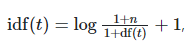
where  is the total number of documents in the document set, and df(t) is the number of documents in the document set that contain term t.  The exact formula for Tf–idf term in sklearn is little different from regular textbook and for details please see sklearn's user guide:
https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
The result is then normalized.

And finally the cosine similarity is used to compute the similarity between the query feature vector and document feature vector.

### Model Architecture and Hyperparameters
Since this is not a deap learning model, these topic is not relavent.  Please see the next transformer model, which include in-depth description and analysis on the its model architecture and hyperparameters

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances, paired_manhattan_distances
from scipy.stats import pearsonr, spearmanr
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import gzip
from datetime import datetime
#!wget https://sbert.net/datasets/stsbenchmark.tsv.gz -P data


# Interface lemma tokenizer from nltk with sklearn
class Tfidf:
    def __init__(self):
        self.model_name = 'Tfidf_sklearn'
        self.wnl = WordNetLemmatizer()
        # Download stopwords list
        nltk.download('stopwords')
        nltk.download('wordnet')
        nltk.download('omw-1.4')
        nltk.download('punkt')
        self.stop_words = set(stopwords.words('english'))
        self.ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
        token_stop = self.get_tokenizer(' '.join(self.stop_words))
        self.Tfidf_vectors = TfidfVectorizer(stop_words=token_stop,
                              tokenizer=self.get_tokenizer)
        self.csv_file = 'similarity_evaluation_' + self.model_name + '_results.csv'
        self.csv_headers = ["cosine_pearson", "cosine_spearman", "euclidean_pearson", \
                            "euclidean_spearman", "manhattan_pearson", \
                            "manhattan_spearman", "dot_pearson", "dot_spearman"]

        self.output_path = 'output/training_stsbenchmark_' + \
            self.model_name.replace("/", "-") + '-' + \
            datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        self.sts_dataset_path = 'data/stsbenchmark.tsv.gz'

    def get_tokenizer(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

    def get_embedding(self, text1, text2):
        text_vectors = self.Tfidf_vectors.fit_transform([text1] + [text2])
        return text_vectors[0].toarray(), text_vectors[1].toarray()

    def get_stopwords(self):
        return self.stop_words

    def get_score(self, embedding1, embedding2):
        cosine_score = 1 - paired_cosine_distances(embedding1, embedding2)[0]
        manhattan_distance = -paired_manhattan_distances(embedding1, embedding2)[0]
        euclidean_distance = -paired_euclidean_distances(embedding1, embedding2)[0]
        dot_product = np.dot(embedding1[0], embedding2[0])
        return cosine_score, manhattan_distance, euclidean_distance, dot_product

    def write_eval(self, cosine_scores, manhattan_distances, euclidean_distances, \
                   dot_products, labels):
        eval_pearson_cosine, _ = pearsonr(labels, cosine_scores)
        eval_spearman_cosine, _ = spearmanr(labels, cosine_scores)
        eval_pearson_manhattan, _ = pearsonr(labels, manhattan_distances)
        eval_spearman_manhattan, _ = spearmanr(labels, manhattan_distances)
        eval_pearson_euclidean, _ = pearsonr(labels, euclidean_distances)
        eval_spearman_euclidean, _ = spearmanr(labels, euclidean_distances)
        eval_pearson_dot, _ = pearsonr(labels, dot_products)
        eval_spearman_dot, _ = spearmanr(labels, dot_products)
        if not os.path.exists(self.output_path):
            os.makedirs(self.output_path)
        csv_path = os.path.join(self.output_path, self.csv_file)
        output_file_exists = os.path.isfile(csv_path)

        with open(csv_path, newline='', mode="a" if output_file_exists else 'w', encoding="utf-8") as f:
            writer = csv.writer(f)
            if not output_file_exists:
                writer.writerow(self.csv_headers)
            writer.writerow([eval_pearson_cosine, eval_spearman_cosine, \
                              eval_pearson_euclidean, eval_spearman_euclidean, \
                              eval_pearson_manhattan, eval_spearman_manhattan, \
                              eval_pearson_dot, eval_spearman_dot])
    def evaluate(self):
        cosine_scores = []
        manhattan_distances = []
        euclidean_distances = []
        dot_products = []
        labels = []
        with gzip.open(self.sts_dataset_path, 'rt', encoding='utf8') as fIn:
            reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
            i=0

            for row in reader:
                i=i+1
                # if i ==3:
                #     break
                label = float(row['score']) / 5.0  # Normalize score to range 0 ... 1

                try:
                    embedding1, embedding2 = self.get_embedding(row['sentence1'], row['sentence2'])
                    cosine_score, manhattan_distance, euclidean_distance, dot_product = \
                    self.get_score(embedding1, embedding2)
                    labels.append(label)
                    cosine_scores.append(cosine_score)
                    manhattan_distances.append(manhattan_distance)
                    euclidean_distances.append(euclidean_distance)
                    dot_products.append(dot_product)
                except Exception:
                    continue

        self.write_eval(cosine_scores, manhattan_distances, euclidean_distances, \
                   dot_products, labels)

In [ ]:
model1 = Tfidf()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
model1.evaluate()

## Models
### Transformer
Transformer, from which the SentenceTransformer model is derived, is a huge improvement over its predecessor, RNN/LSTM without or with an attention mechanism.  It uses the idea of self-attention and positional embedding to essentially remove the necessity to process input embeddings in sequence, and is able to process embeddings in parallel, which is much more efficient, and also removes other inefficiencies.  As a result, transformer can process much longer text and run much faster.  




Image source: https://www.tensorflow.org/text/tutorials/transformer
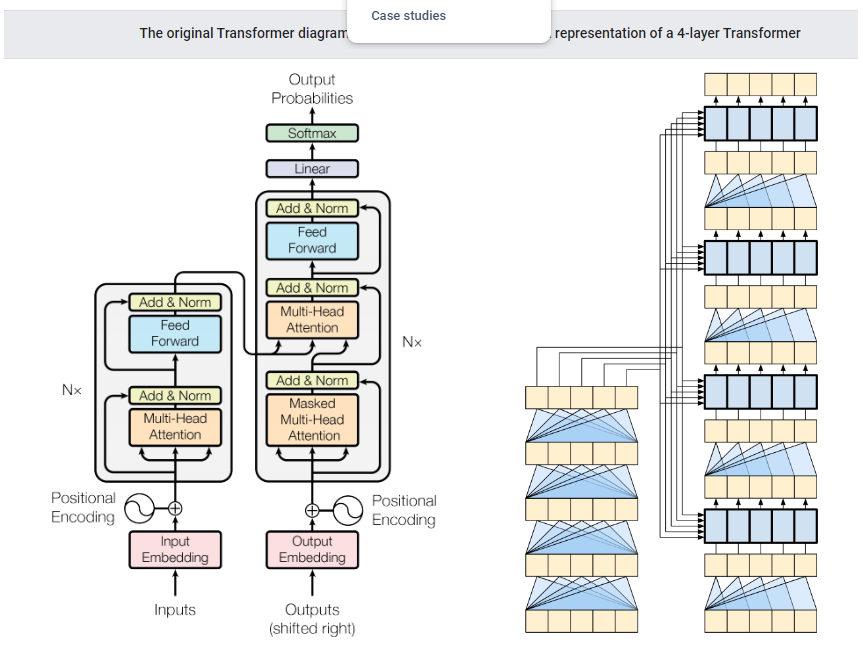

### Reason Sentence Transformer is chosen?
The transformer from the original paper is actually a encoder and decoder designed for sequence-to-sequence tasks.  There are many variants come out afterward that are either improvement or for specific tasks.  BERT is one that only consists of encoder, which is great for making sequence/text embedding. What really make BERT and transformer amazing is the idea of self-supervised learning that it can be pre-trained on huge amount of unlabeled text, like billions of examples, as a result, it is able to extract language features no matter how subtle it is.  The pre-trained models are widely available for anyone to use on their specific tasks such as STS by fine-tuning only on small training examples available and using much less computing resources and less time.
All the above make transformers extremely powerful and state-of-the-art model.

SentenceTransformers is a framework for state-of-the-art sentence, text and image embeddings. These embeddings can then be compared with cosine-similarity to find sentences with a similar meaning. This can be useful for semantic textual similar, semantic search, or paraphrase mining. Sentence Transformer was developed by sbert.net that is based on huggingface's implementation of transformer.  The framework provides convenient API for training or perform STS tasks so you don't have to code the implementation.  It also provide out-of-box fine-tuned model weights for STS specific tasks. They claim their models  achieve state-of-the-art performance on the above mentioned tasks, therefore this their model is chosen as a deep learning model for STS.
The models I chose under this framework is all-mpnet-base-v2 and  all-MiniLM-L6-v2.  "The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality."
The second reason is of course ease of coding.  "SentenceTransformers was designed in such way that fine-tuning your own sentence / text embeddings models is easy. It provides most of the building blocks that you can stick together to tune embeddings for your specific task."

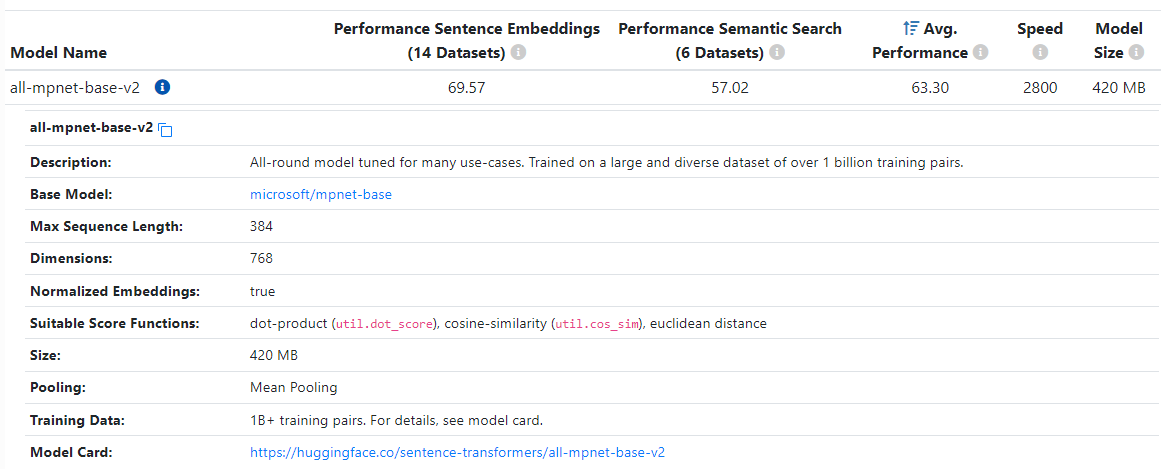

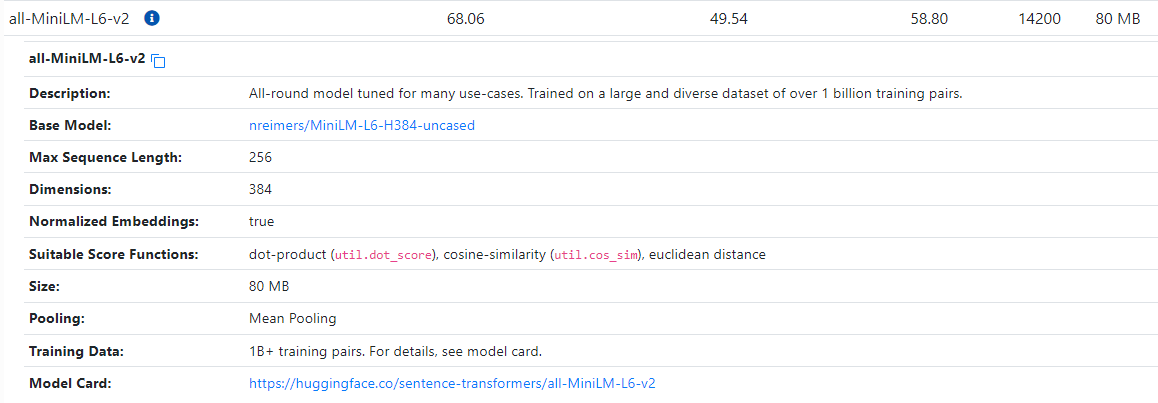

### How does the Sentence Transformer Model Training Work?
Which training strategy to use mainly depends the training dataset, where it come from and its content, and of course your task at hand.  For example STS and paraphrase mining would have very different approach to traning methods.  For sts in this project, I will fine-tune on STS benchmark dataset using the default network architecture, though you could add pooling layers and dense layers on top of the network through their API:
InputExample class takes three parameters, sentence 1 and 2, and score label.
Sentence 1 and 2 pass through trasformer embedding layer and become two embeddings.  Then cosine similarity function is used in loss function against score label for the optimization objective, which is to minimize the cosine similarity loss with CosineSimilarityLoss object.
In the offically evaluated and recognized models by sentence transformer, I didn't find model specifically fine-tuned for STS.  So I will use the all purpose one out-of-box and fine-tune it on STS benchmark dataset and compare the result.  See the Result and Analysis section for detail.  In a sence, STS benchmark dataset serve the purpose of assessing different model's performance as well as training and evaluation on a model.
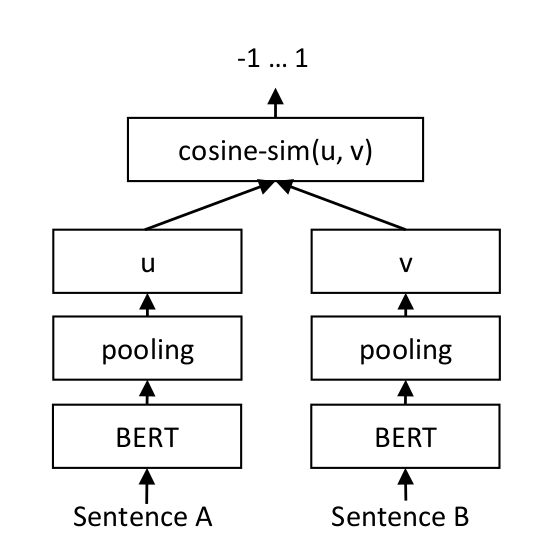

For details, please check the following link:
https://www.sbert.net/docs/package_reference/losses.html
### Model Traning and Evaluation Metrics
For training, it is cosine similarity and it is built-in in the framework.  For evaluation, I used cosine, manhaten, eucleadience and dot product metrics.  Each may give a slightly different scores, depending on how you define similarity for your task.

### Hyperparameters Tuneing
Since transformer is a very complex model, there are many hyperparameters.  Just those associated with model architecture alone include how many layers of transormer blocks, in each block, the dimention of embeding layer, attention layer, number of attention heads, layer normalization parameter etc.  Performing tuning on these hypermarameters are very challenge tasks and because of these sentence transformer take care of most of it so as user you don't need to worry about it.  The API only expose batch number, step number and epoch.  The first two just depend on the size of your training data and your machine memory.  The only meaningful hyperparameter for this model as far as this project concerned, is just the epoch number.  See Result and Analysis for more information.
Having said that sentence transformer framework does provided several "endorsed" pre-trained models for you to choose from.  Selection of these models serve the same purpose of huperparameter tuning, after all we want to find the best performing model for our task.  For the following models, exluding those fine-tuned for multi-language and other tasks such as paraphrase and QA etc, I select all-mpnet-base-v2, for it is general purpose and has highest overall performance score, and all-MiniLM-L6-v2, which scores not much lower than all-mpnet-base-v2 but has 1/5 size of all-mpnet-base-v2.
If you really want to know what kind of dataset is the model pre-trained on, just click the base model link.  For example, click the base model for all-MiniLM-L6-v2, it shows it is based on the 6 layers version by nreimen of the
MiniLM-L12-H384-uncased by microsoft, which is a "uncased 12-layer model with 384 hidden size distilled from an in-house pre-trained UniLM v2 model in BERT-Base size."  it is then fine-tuning on NLU tasks.  The GLUE benchmark score is also shown.
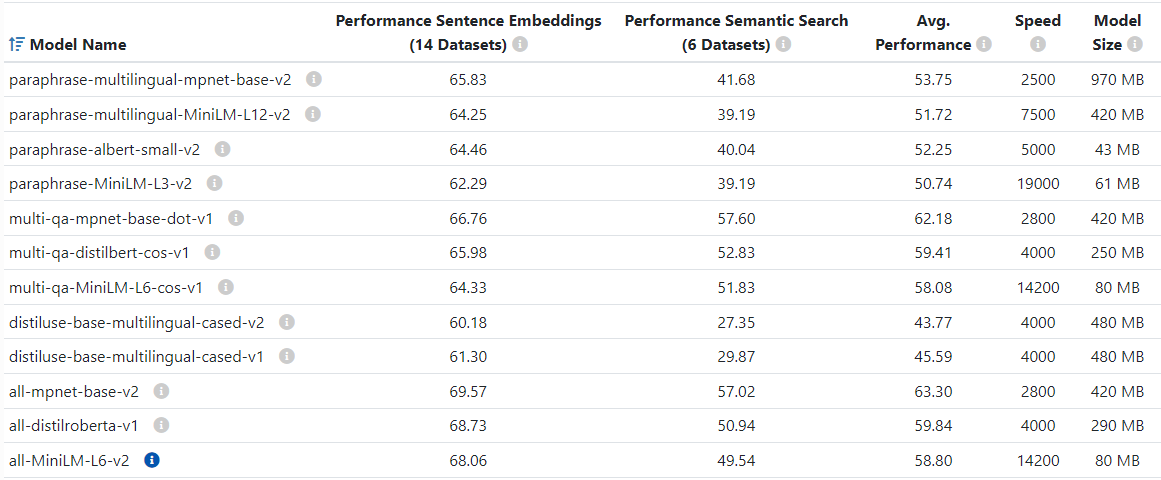

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer,  util, losses, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import sys
import torch
import gzip
import os
import csv

class Transformer_sts:
    def __init__(self):
        #self.model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        #self.model = SentenceTransformer('sentence-transformers/nli-distilroberta-base-v2')
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
        self.sts_dataset_path = 'data/stsbenchmark.tsv.gz'
        self.model_save_path = 'models'
        self.eva_out_path = 'output/data'
        self.train_samples, self.dev_samples, self.test_samples, self.evaluator = \
        self.get_samples()

    def get_samples(self):
        if not os.path.exists(self.model_save_path):
            os.makedirs(self.model_save_path)
        if not os.path.exists(self.eva_out_path):
            os.makedirs(self.eva_out_path)
        dev_samples, test_samples, train_samples = [], [], []
        with gzip.open(self.sts_dataset_path, 'rt', encoding='utf8') as fIn:
            reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
            for row in reader:
                score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
                inp_example = InputExample(texts=[row['sentence1'], row['sentence2']], label=score)

                if row['split'] == 'dev':
                    dev_samples.append(inp_example)
                elif row['split'] == 'test':
                    test_samples.append(inp_example)
                else:
                    train_samples.append(inp_example)
        evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')
        return train_samples, dev_samples, test_samples, evaluator

    def train(self, train_batch_size=16, num_epochs=4):
        train_dataloader = DataLoader(self.train_samples, shuffle=True, batch_size=train_batch_size)
        train_loss = losses.CosineSimilarityLoss(model=self.model)
        warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
        self.model.fit(train_objectives=[(train_dataloader, train_loss)],
                  evaluator=self.evaluator,
                  epochs=num_epochs,
                  evaluation_steps=1000,
                  warmup_steps=warmup_steps,
                  output_path=self.model_save_path)

    def evaluate(self):
        self.evaluator(self.model, self.eva_out_path)
model2 = Transformer_sts()






Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
model2.train(num_epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

In [ ]:
model2.evaluate()

## Result and Analysis

### How is the Result Table Organized
The first row contains STS benchmark scores for TF-IDF.  Since it is not a supervised learning algorithm, training related columns such as training time, epoch, steps do not apply.  Row 3,4,5 are benchmark scores for pre-trained transformer models and are evaluated out-of-box; there are no training related fields filled either.
6 to 11 rows contains information for the fine-tuned models on STS benchmark training data, as you can see the training length, epoch number used for fine-tuning, and steps, which depends on the training example length and batch size.  Default 16 batch size were used.  You also see the model size and the embedding dimension size, which is the size of the embedding space after the input sentence is transformed into.  As you can see it is fixed no matter the length of the input sentence and that is just how the transformer works.


## What does the Metrics Mean and How are They used
The similarity functions used to get the similarity score between two embeddings are cosine, euclidean, manhattan, and dot product.  Some of the metrics may be more relevant than the others depending on your tasks and the input text sources.  For example, dot product tend to favor embeddings with high norm.  Sentences containing popular words may have high norms, so choose the metrics more relevant to your applications for assessment.

For measuring how close and therefore how good a model evaluates against the benchmark, Pearson and Spearman correlation coefficients are used.  Both have values between -1 and 1 with 0 imply no correlation between similarity predictions and benchmark labels and -1 and 1 exact correlations.  For Pearson, it measures the linear relationship between predictions and benchmark labels and Spearman a nonparametric measure of the monotonicity of the relationship between them.
For this project, the higher the value, the higher the performance of the evaluated model is.


## Hyperparameter Tuning
Two epoch values were used to see if the fine-tuning would yield improved performance.  The three models I am comparing were fine-tuned on STS benchmark training data for 4 epoch and 20 epoch each.  The result is interesting that all the big models (420MB and 329MB) improve with 20 epoch over 4 by a little,  but the small model (80MB) performance actually dropped a little with longer training. (Please refer to the result table).  The explanation is smaller models with a lot fewer parameters and half the result embedding dimensions, tend to converge faster with the same amount of training examples, and therefore longer training will drop the performance a little.

## Explaination and Conclusion

### Deep Learning vs. Non-Deep Learning
From the result table we can see TF-IDF scores way below any transformer models, fine-tuned or not, with the max score, the cosine pearson of 0.6948 and the minimum score from transformers of 0.8472.
TF-IDF uses a collection of unigrams (bag of words) as input and therefore cannot capture phrases and multi-word expressions, effectively disregarding any word order dependence. Additionally, the bag of words model doesn’t account for potential misspellings or word derivations.
Whereas transformers can take much longer text input and have been pre-trained on billions of training examples that they are far more capable models in terms of language understanding in general.
So there is no surprise deep learning model such as transformer outperformance non-deep learning model by large margin on STS tasks and probably on any other NLP tasks too.
Transformer models do need to be pre-training on huge amounts of data and the training does require some hardware requirement and may take a long time, weeks or even months.  Fortunately there are platforms such as hugging face providing hubs for a large collection of publicly available models for all kinds of tasks so that you no longer need to worry about pre-training.

### Fine-tuned vs. Pre-trained
From the result table we can see across all metrics, and for all three models, fine-tuned on STS benchmark training examples have higher scores than pre-trained.  This is of course expected because the three models were previously trained for general purpose (the "all" prefix in their names indicate general purpose) and nli-distilroberta-base-v2 was tuned for NLI tasks, which are somewhat different from STS, by fine-tuning these models on STS training sets, of course they perform better on STS eval dataset since eval and train dataset come from same source, they were just split by random.  In practice, if you really want a state-of-the-art STS model, fine-tune on STS benchmark training data might not be ideal and you probably need a larger and more diverse dataset, like I already demonstrated in the EDA section.
It is interesting to notice that everything else being equal, nli-distilroberta-base-v2 scores lower than all-mpnet-base-v2 and all-MiniLM-L6-v2 since NLI tuned models perform worse than general purpose models for STS tasks.

### Transformer Large Model vs. Small Model
all-mpnet-base-v2 has a size of 420MB yet only performs a small fraction better than all-MiniLM-L6-v2, which has a size of 80MB only.  So if you want to deploy the model in a platform where memory is constrained, all-MiniLM-L6-v2 would be ideal than all-mpnet-base-v2.

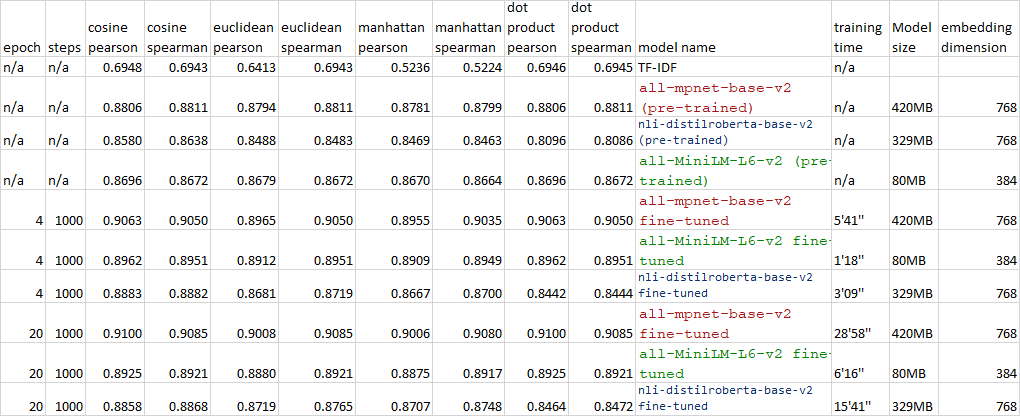

# Furthur Thoughts
I picked these three particular models from huggingface hub because one of them was used in Sentence Transformer user guide example.  I could spend more time search and experimenting on other available models on huggingface hub.  It is difficult to find a model exactly match your need since there are so many deep learning applications and tasks out there, so more likely than not you will need to fine-tune your model for your need, especially it is not popular or the model is difficult to train in that particular case, for example, large text generation model, which has size of trillions of parameters.  So everything comes down to labeled dataset again, which is the limiting factor.  In STS case, it is unlikely to find a large labeled dataset, especially if the sentence is very long, as it takes a while for humans to read, interpret and rate the semantic similarity.  So anyone can come up and idea of efficiently and automatically collect large about of labeled STS data can really push the model performance forward.


# References

Sentence Transformers: Multilingual Sentence, Paragraph, and Image Embeddings using BERT & Co.
https://github.com/UKPLab/sentence-transformers

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

scipy.stats.spearmanr
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
The Pearson correlation coefficient [1] measures the linear relationship between two datasets.

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
sklearn.feature_extraction.text.TfidfVectorizer

How to Rank Text Content by Semantic Similarity
https://towardsdatascience.com/how-to-rank-text-content-by-semantic-similarity-4d2419a84c32

STS benchamrk
https://ixa2.si.ehu.eus/stswiki/index.php/STSbenchmark